# Model evaluation

In [47]:
import sys
sys.path.append('../')
from fastai.vision.all import *
from mocatml.data import *
from mocatml.utils import *
from tsai.imports import my_setup
from tsai.utils import yaml2dict, dict2attrdict
from mygrad import sliding_window_view
import wandb

In [15]:
my_setup()

os              : Linux-6.2.0-37-generic-x86_64-with-glibc2.31
python          : 3.9.17
tsai            : 0.3.8
fastai          : 2.7.13
fastcore        : 1.5.29
torch           : 2.1.1+cu121
device          : cpu
cpu cores       : 4
threads per cpu : 2
RAM             : 15.3 GB
GPU memory      : N/A


In [57]:
config = yaml2dict('./config/convgru/eval.yaml')
config

```json
{ 'data': { 'path': '~/arclab_shared/mc_density_data/comb_am_rp.npy',
            'split_idx': 1},
  'device': 'cpu',
  'horizon': None,
  'learner': { 'fname': 'learner.pkl',
               'path': 'vrodriguezf90/mocatml/density-forecaster:v3',
               'wandb': { 'dir': '~/Github/mocat-ml',
                          'download_path': 'wandb/artifacts/density-forecaster',
                          'enabled': True}},
  'lookback': None,
  'mmap': True,
  'norm': {'mean': None, 'std': None},
  'sel_steps': None,
  'stride': None}
```

In [17]:
# Set device
default_device(0 if config.device == 'cpu' else config.device)

device(type='cpu')

In [18]:
wandb_api = wandb.Api()
if config.learner.wandb.enabled:
    ar = wandb_api.artifact(config.learner.path)
    lp = ar.download(root= Path(config.learner.wandb.dir).expanduser()/\
                            Path(config.learner.wandb.download_path))
    lp = lp/Path(config.learner.fname)
else:
    lp = Path(config.learner.path)/Path(config.learner.fname)
learn = load_learner(lp, cpu=default_device() == torch.device("cpu"))
learn

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Path /workspaces/mocat-ml /wandb/ wasn't writable, using system temp directory.
wandb: WARNING Path /workspaces/mocat-ml /wandb/ wasn't writable, using system temp directory
wandb: Downloading large artifact density-forecaster:v3, 490.62MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:0.9
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [58]:
if config.learner.wandb.enabled:
    run = ar.logged_by()
    config.lookback = run.config['lookback']
    config.horizon = run.config['horizon']
    config.sel_steps = run.config['sel_steps']
    config.stride = run.config['stride']

In [25]:
X = np.load(Path(config.data.path).expanduser(), 
               mmap_mode='c' if config.mmap else None)
if config.data.split_idx is not None:
    X = X[learn.splits[config.data.split_idx], :config.sel_steps]
X.shape

(20, 100, 36, 99)

In [59]:
X_sw = sliding_window_view(X, (X.shape[0], config.lookback + config.horizon, 
                                 X.shape[-2], X.shape[-1]), 
                                 (X.shape[0], config.stride, 
                                  X.shape[-2], X.shape[-1]))
samples_per_simulation = X_sw.shape[1]
X_sw = X_sw.squeeze()
X_sw = X_sw.reshape(-1, *X_sw.shape[2:])
X_sw.shape

(380, 8, 36, 99)

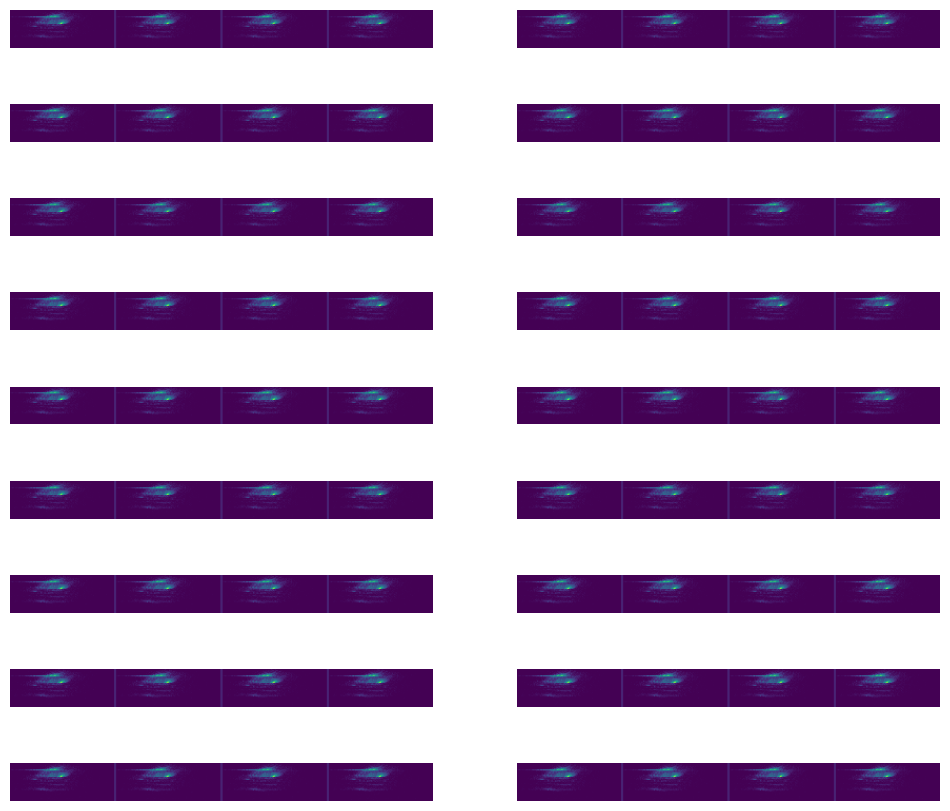

In [64]:
train_stats = (learn.dls.train.after_batch.mean, learn.dls.train.after_batch.std)
ds = DensityData(X_sw, lbk=config.lookback, h=config.horizon)
tl = TfmdLists(range(len(ds)), DensityTupleTransform(ds))
dl = TfmdDL(tl, bs=learn.dls.valid.bs, shuffle=False, num_workers=0, 
            after_batch=Normalize.from_stats(*train_stats))
dl.show_batch()

In [65]:
learn.validate(dl=dl)

(#1) [108.6268081665039]